In this file we will use a Neural Network to classify speakers. We will use a RNN with the melspectrogam coefficients feature, that proved to be effective in the machine learning section and is better suited than the melspec feature because the images are smaller and the computational time will be shorter. This time we wont flatten the spectogram because we want to mantain the temporal aspect of the feature

**Importing libraries**

In [1]:
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile as wav
from librosa.feature import melspectrogram, mfcc

# Had to use pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import load_model

import re

from sklearn.metrics import classification_report, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix 


Setting path variable:

In [2]:
path = os.getcwd() + '\\data\\'
print(path)

c:\Users\Emili\DSIM_project\ID\data\


### **Loading data**

In [3]:
# Data loader
def load_data(feature_extractor, train_size):
  
  X_train = []
  y_train = []

  X_test = []
  y_test = []

  random.seed(10) # For reproducibility

  random.shuffle(os.listdir(path))
  for speaker in os.listdir(path):
    tracks = os.listdir(path + speaker)
    random.shuffle(tracks) # We don't want the first seconds to systematically
                           # be train and the last to be test
    track_num = 0
    for track in tracks:
      track_num = track_num + 1
      _, signal = wav.read(path + speaker + '/' + track)

      if track_num <=np.floor(train_size*len(tracks)):
        X_train.append(feature_extractor(signal))
        y_train.append(speaker)
      else:
        X_test.append(feature_extractor(signal))
        y_test.append(speaker)
        
        
  for i in range(len(y_train)):
    m = re.search(r'\d+$', y_train[i])
    y_train[i] = int(m.group())-1


  for i in range(len(y_test)):
      m = re.search(r'\d+$', y_test[i])
      y_test[i] = int(m.group())-1
    
  y_test = np.array(y_test)
  y_train = np.array(y_train)
        
  
  eps = 0.001
  X_train = np.array(X_train)
  X_train_mean = X_train.mean(axis=0)
  X_train_std = X_train.std(axis=0)
  X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
  X_test = np.array(X_test)
  X_test = (X_test - X_train_mean + eps)/(X_train_std + eps)

  return X_train, X_test, y_train, y_test

def feats_mfcc(input, rate = 8000):
  input = mfcc(y = input*1.0, sr = rate)
  output = np.transpose(input)
  return output

In [4]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, train_size=0.8)

### **Gate Recurrent Unit (GRU) Neural Network**

Just one layer of GRU, followed by a dense layer with softmax activation was enough to get great performances on the test set thanks to the abundance of data

In [5]:
features_input = keras.Input((157, 20), batch_size=64)
x = keras.layers.GRU(16, return_sequences=False, dropout=0.2)(features_input)
output = keras.layers.Dense(24, activation='softmax')(x)
net = keras.Model(features_input, output)

In [6]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 157, 20)]           0         
                                                                 
 gru (GRU)                   (64, 16)                  1824      
                                                                 
 dense (Dense)               (64, 24)                  408       
                                                                 
Total params: 2,232
Trainable params: 2,232
Non-trainable params: 0
_________________________________________________________________


In [7]:
net.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop',
            metrics=['accuracy'])

In [8]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.01,
    patience=5,
    baseline=None,
    restore_best_weights=True,
)

In [9]:
# Train model
history = net.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks = [callback]
)

Epoch 1/30
237/237 [==============================] - 12s 44ms/step - loss: 2.9576 - accuracy: 0.1298 - val_loss: 2.6351 - val_accuracy: 0.2371
Epoch 2/30
237/237 [==============================] - 10s 42ms/step - loss: 2.3596 - accuracy: 0.3120 - val_loss: 2.0500 - val_accuracy: 0.4148
Epoch 3/30
237/237 [==============================] - 10s 43ms/step - loss: 1.8577 - accuracy: 0.4925 - val_loss: 1.6080 - val_accuracy: 0.5555
Epoch 4/30
237/237 [==============================] - 10s 42ms/step - loss: 1.4454 - accuracy: 0.6292 - val_loss: 1.2276 - val_accuracy: 0.6899
Epoch 5/30
237/237 [==============================] - 10s 42ms/step - loss: 1.0743 - accuracy: 0.7425 - val_loss: 0.9237 - val_accuracy: 0.7629
Epoch 6/30
237/237 [==============================] - 10s 43ms/step - loss: 0.8306 - accuracy: 0.7994 - val_loss: 0.7266 - val_accuracy: 0.8192
Epoch 7/30
237/237 [==============================] - 10s 44ms/step - loss: 0.6596 - accuracy: 0.8440 - val_loss: 0.5900 - val_accuracy:

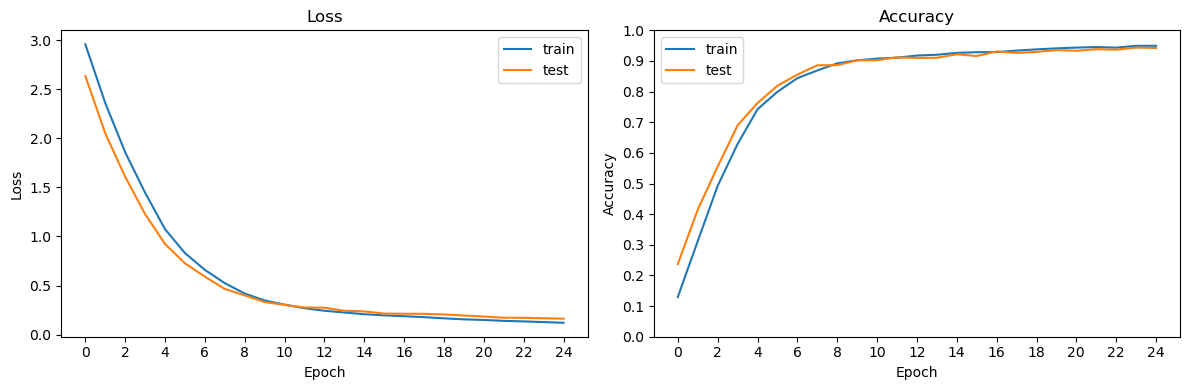

In [10]:
# Visualization of the learning curves
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.xticks(np.arange(0, len(history.history['loss']), 2),
           np.arange(0, len(history.history['loss']), 2, dtype=int))
plt.title('Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.title('Accuracy')
plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-axis tick marks from 0 to 1 with a step of 0.1
plt.xticks(np.arange(0, len(history.history['accuracy']), 2),
           np.arange(0, len(history.history['accuracy']), 2, dtype=int))

plt.tight_layout()
plt.show()

In [11]:
def get_classification_report(y_test, y_pred):

    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.round(3)
    df_classification_report = df_classification_report.drop(['weighted avg'])
    df_classification_report['support'] = df_classification_report['support'].astype(int)
    df_classification_report['accuracy'] = np.nan
    df_classification_report = df_classification_report[['accuracy', 'precision', 'recall', 'f1-score', 'support']]
    df_classification_report['accuracy']['macro avg']= df_classification_report['precision']['accuracy']
    df_classification_report = df_classification_report.drop(['accuracy'], axis=0)
    df_classification_report.rename({'macro avg': 'average'}, axis=0, inplace=True)
    return df_classification_report

In [12]:
yc_pred = net.predict(X_test)
y_pred = np.argmax(yc_pred, axis=1)
classification_report_gru = get_classification_report(y_test, y_pred)
print('\nClassification report for GRU (test set):')
classification_report_gru

60/60 [==============================] - 1s 8ms/step

Classification report for GRU (test set):


,accuracy,precision,recall,f1-score,support
0,NaN,0.857,0.825,0.841,80
1,NaN,0.925,0.925,0.925,80
2,NaN,0.626,0.712,0.667,80
3,NaN,0.899,1.000,0.947,80
4,NaN,0.855,0.812,0.833,80
5,NaN,0.988,0.988,0.988,80
6,NaN,0.667,0.525,0.587,80
7,NaN,0.964,1.000,0.982,80
8,NaN,1.000,1.000,1.000,80
9,NaN,1.000,0.962,0.981,80


As we can see almost every class has very high precision and recall except:
- speaker_2
- speaker_6

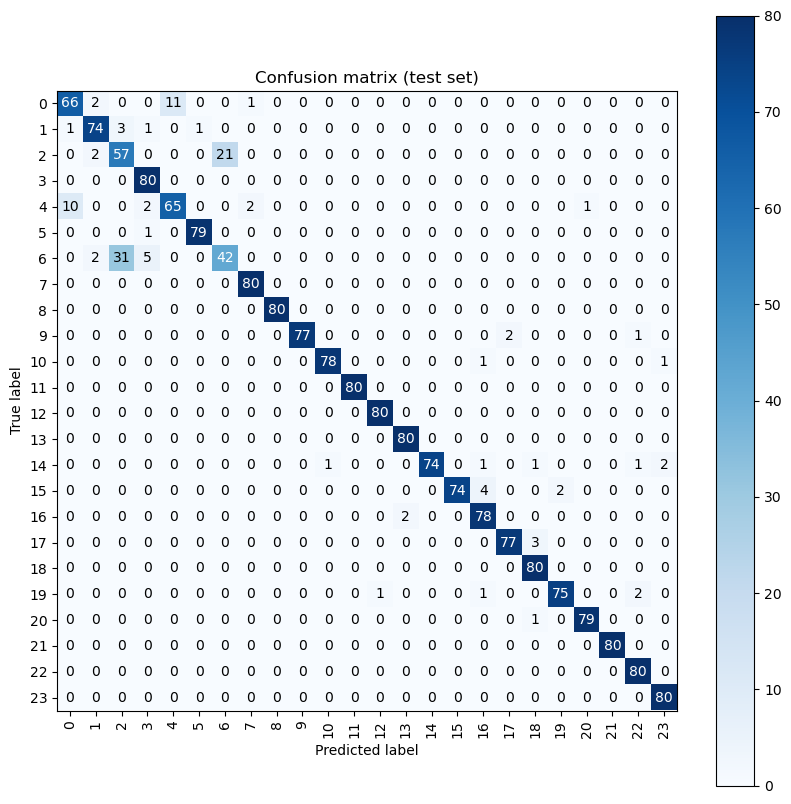

In [13]:
plot_confusion_matrix(y_test, y_pred, x_tick_rotation=90, figsize=(10,10),
                      title='Confusion matrix (test set)');

To be more specific, speaker_2 instances tend to be classified as speaker_6 and viceversa

Overall, this neural network slighlty outperforms the Random Forest classifier on the test set (94% over 92% accuracy) and also overfits less on the train set (has 95% accuracy instead of 99%). It is also much faster to train and predict

In [161]:
classification_report_gru.to_csv(os.getcwd() + '\\GRU_performances.csv',
                                index = True)

In [162]:
net.save('GRU_ID.h5')